### Sources

https://www.pymc.io/projects/docs/en/latest/learn/core_notebooks/pymc_overview.html

https://www.kaggle.com/datasets/crowdflower/twitter-airline-sentiment/data?select=Tweets.csv

https://success.appen.com/hc/en-us/articles/202703305-Getting-Started-Glossary-of-Terms#unit

https://www.geeksforgeeks.org/role-of-log-odds-in-logistic-regression/

https://www.pymc.io/projects/docs/en/v3/pymc-examples/examples/getting_started.html

https://www.stat.cmu.edu/~brian/463-663/week10/Chapter%2009.pdf

https://www.youtube.com/watch?v=pbcxb9xpTBI&ab_channel=PyData

https://link.springer.com/article/10.1007/s00180-022-01287-4#:~:text=Bayesian%20multilevel%20(or%20hierarchical)%20logistic,values%20of%201%20or%200).

https://www.pymc.io/projects/docs/en/v3.11.4/pymc-examples/examples/generalized_linear_models/GLM-logistic.html

https://www.pymc.io/projects/docs/en/v3/pymc-examples/examples/case_studies/multilevel_modeling.html

https://www.pymc.io/projects/examples/en/latest/mixture_models/dirichlet_mixture_of_multinomials.html#multinomial-model

### Imports and load data

In [1]:
import pymc as pm
import arviz as az
az.style.use("arviz-darkgrid")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import plotly.offline as pyo
import plotly.io as pio
pyo.init_notebook_mode(connected=True)

In [2]:
df = pd.read_csv('Tweets.csv')

pd.set_option('display.max_columns', None)

In [3]:
palette = ['#003f5c', '#2d6187', '#4b7db2', '#6796dd', '#84afed',
           '#006d44', '#008b5c', '#00a970', '#00c87f', '#00e78c']

## Exploratory Data Analysis (EDA)

### Data set

In [4]:
rows = len(df)
cols = len(df.columns)
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


The data set is called  'Twitter US Airline Sentiment' and has 14 640 rows and 15 columns. Each row represents a "tweet" with information about the user and the sentiment of the "tweet" along with the original text.

### Missing values

In [5]:
missing = pd.concat([df.isna().sum(),(df.isna().sum() / rows)*100],axis=1).round(2)
missing.columns = ['Number of missing values','Percentage']
missing

,Number of missing values,Percentage
tweet_id,0,0.00
airline_sentiment,0,0.00
airline_sentiment_confidence,0,0.00
negativereason,5462,37.31
negativereason_confidence,4118,28.13
airline,0,0.00
airline_sentiment_gold,14600,99.73
name,0,0.00
negativereason_gold,14608,99.78
retweet_count,0,0.00


The data set has a large number of missing values in some of the columns. If we look at the feature *negativereason*, it is clear that it is supposed to have missing values since it will only be non-null if the tweet was was marked with 'negative' sentiment. 
Before discarding any features with missing values, it is interesting to look at what the reasons were for 'negative' tweets.

In [6]:
df_neg = df[~df['negativereason'].isna()]
counts = df_neg.groupby(['negativereason']).size().reset_index(name='Count')

fig = px.bar(counts, 
             x='negativereason', 
             y='Count', 
             color='negativereason',
             labels={'negativereason': 'Sentiment', 'Count': 'Occurrences'},
             barmode='group',
             color_discrete_sequence=palette)

fig.update_layout(
    title='',
    xaxis_title='Negative Reason',
    yaxis_title='Number of tweets',
    legend_title_text='',
    showlegend=True
)

fig.show()

It is clear that the main reasons for having a bad flight experience is due to customer service issues and delayed flights. 

Next we will drop all columns that had more than 25% missing values and we are left with only 8 columns.

In [7]:
threshold = 25
df_new = df.dropna(axis=1, thresh=int(df.shape[0] * (1 - threshold / 100)))
df_new.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,airline,name,retweet_count,text,tweet_created
0,570306133677760513,neutral,1.0000,Virgin America,cairdin,0,@VirginAmerica What @dhepburn said.,2015-02-24 11:35:52 -0800
1,570301130888122368,positive,0.3486,Virgin America,jnardino,0,@VirginAmerica plus you've added commercials t...,2015-02-24 11:15:59 -0800
2,570301083672813571,neutral,0.6837,Virgin America,yvonnalynn,0,@VirginAmerica I didn't today... Must mean I n...,2015-02-24 11:15:48 -0800
3,570301031407624196,negative,1.0000,Virgin America,jnardino,0,@VirginAmerica it's really aggressive to blast...,2015-02-24 11:15:36 -0800
4,570300817074462722,negative,1.0000,Virgin America,jnardino,0,@VirginAmerica and it's a really big bad thing...,2015-02-24 11:14:45 -0800


Focusing on the *airline_sentiment* column, we can see that more than 60% of tweets in the data set were of a negative sentiment, followed by 21% neutral and 16% positive. The confidence score for all three sentiment classes were high with negative tweets confidence score the highest at 93%. 

In [8]:
sentiment_counts = df_new.groupby(['airline_sentiment']).size().reset_index(name='Count')

sentiment_totals = pd.concat([sentiment_counts,(sentiment_counts['Count'] / rows)*100],axis=1).round(2)
sentiment_totals.columns = ['airline_sentiment','Count','Percentage of tweets']

avg_conf = df_new.groupby('airline_sentiment')['airline_sentiment_confidence'].mean()

sentiment_totals['Mean confidence'] = avg_conf.values

sentiment_totals

,airline_sentiment,Count,Percentage of tweets,Mean confidence
0,negative,9178,62.69,0.933365
1,neutral,3099,21.17,0.823303
2,positive,2363,16.14,0.872039


In [9]:
fig = px.bar(sentiment_counts, 
             x='airline_sentiment', 
             y='Count', color='airline_sentiment',
             labels={'airline_sentiment': 'Sentiment', 'Count': 'Occurrences'},
             barmode='group',
             color_discrete_sequence=palette)

fig.update_layout(
    title='',
    xaxis_title='Sentiment',
    yaxis_title='Number of tweets',
    legend_title_text='',
    showlegend=True
)

fig.show()

Tweets include sentiment on six different airlines. Most tweets were about United airlines followed by US Airways and American airlines. Looking at the bar chart it is interesting to note that Virgin America airlines had approximately the same number of neutral, positive, and negative tweets whereas the top three airlines had a large proportion of negative tweets compared to neutral and positive.

In [10]:
contingency_table = pd.crosstab(df_new['airline_sentiment'], df_new['airline'],margins=True)
contingency_table

airline,American,Delta,Southwest,US Airways,United,Virgin America,All
airline_sentiment,,,,,,,
negative,1960,955,1186,2263,2633,181,9178
neutral,463,723,664,381,697,171,3099
positive,336,544,570,269,492,152,2363
All,2759,2222,2420,2913,3822,504,14640


In [11]:
group_counts = df_new.groupby(['airline', 'airline_sentiment']).size().unstack().reindex(df_new['airline'].unique()).fillna(0)

fig = go.Figure()

for i, group in enumerate(group_counts.columns):
    fig.add_trace(go.Bar(
        x=group_counts.index,
        y=group_counts[group],
        name=group,
        marker=dict(color=palette[i % len(palette)])
    ))

fig.update_layout(
    title='',
    xaxis_title='Airline',
    yaxis_title='Number of tweets',
    barmode='group',
    showlegend=True,
    bargap=0.1
)

fig.show()

Each tweet has a timestamp at which it was created. It does not seem like time of the day has an effect on the sentiment of the tweet. Looking at the bar chart we can see that all tweet sentiments have the same trend with more tweets being made in the day time than night.

In [19]:
df_new.loc[:,'hour_of_day'] = pd.to_datetime(df_new['tweet_created']).dt.hour

grouped = df_new.groupby(['hour_of_day', 'airline_sentiment']).size().reset_index(name='count')

traces = []
for i, sentiment in enumerate(grouped['airline_sentiment'].unique()):
    sentiment_data = grouped[grouped['airline_sentiment'] == sentiment]
    trace = go.Scatter(
        x=sentiment_data['hour_of_day'],
        y=sentiment_data['count'],
        mode='lines+markers',
        name=sentiment,
        line=dict(color=palette[i % len(palette)]),
        marker=dict(color=palette[i % len(palette)])
    )
    traces.append(trace)

layout = go.Layout(
    title='',
    xaxis=dict(title='Time'),
    yaxis=dict(title='Number of tweets')
)

fig = go.Figure(data=traces, layout=layout)
fig.show()

## Model specification and fitting

https://online.stat.psu.edu/stat504/book/export/html/667#:~:text=The%20multinomial%20distribution%20arises%20from,%3D%201%20%2C%20%E2%80%A6%20%2C%20k%20.

It is difficult to know the exact sentiment of tweets made by humans as sentiment cannot be easily inferred from text. One would think that most people do not have the best experience with airlines and we can use this as *prior* knowledge for our model. We are trying to estimate the posterior probabilities of the *airline_sentiment* variable that has three classes. Since the variable has categorical outcome with more than two classes, we can use the Multinomial distribution to model the posterior probabilities and the priors from a Dirichlet distribution.

The Multinomial Distribution can be described as the following:
We have $n$ number of trails and each trail has $k$ mutually exclusive outcomes say $E_1, E_2, ..., E_k$. Each outcome $E_j$ can occur with probability $\pi_j, j = 1,2,..., k$.
Let $X_j$ be the count of the number of trials with outcome $E_j$, so $X = (X_1, X_2, ..., X_k)$ is a random vector with a multinomial distribution:
$X$ ~ $Mult(n,\pi)$, with $n$ the number of trails and parameter vector $\pi = (\pi_1, \pi_2, ..., \pi_k)$.

Referring to the Twitter US Airline Sentiment data we can say that we have $n = 14640$ tweets as our number of trails and we have three different sentiment outcomes, $E_1 = neutral, E_2 = positive, E_3 = negative$. The probability of each outcome is denote by the vector $\pi = (0.212, 0.161, 0.627)$. 

### Simple Model

First we try a simple model that tries to estimate the posterior probabilities with the Multinomial distribution and we specifiy strong priors for the airline sentiments that follow a Dirichlet distribution. 

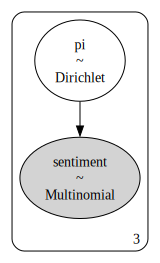

In [13]:
df['airline_sentiment'] = pd.factorize(df['airline_sentiment'])[0]
group_counts = df.groupby(['airline_sentiment']).size()

N = rows
priors = [2.0, 1.0, 5.0]

observed_counts = group_counts.values

num_sentiments = len(df['airline_sentiment'].unique())

with pm.Model() as simple_model:
    probs = pm.Dirichlet(name='pi', a=priors, shape=num_sentiments)
    
    multinomial_dist = pm.Multinomial('sentiment', n=N, p=probs, observed=observed_counts)
    
pm.model_to_graphviz(simple_model)

Next we simulate data from the model and check the parameter summary table. We can see that the mean value for each posterior probability is exactly equal to the proportions in the observed data. The 94% highest density interval is very narrow so that means we are fairly confident that the true proportions lies within this range. The Gelman-Rubin statistic, or $\hat{R}$, is a measure of convergence for the simulated chains. An $\hat{R}$ value equal to one is ideal since it suggests convergence. When looking at the trace plots below, it is clear that the parameters and its posteriors are moving together.

In [14]:
with simple_model:
    samples = pm.sample(1000, tune=1000, target_accept=0.99)
    
summary = pm.summary(samples)
summary

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [pi]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 37 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
pi[0],0.212,0.003,0.205,0.218,0.0,0.0,1171.0,1506.0,1.0
pi[1],0.161,0.003,0.156,0.167,0.0,0.0,1297.0,1457.0,1.0
pi[2],0.627,0.004,0.620,0.634,0.0,0.0,2742.0,2462.0,1.0


array([[<Axes: title={'center': 'pi'}>, <Axes: title={'center': 'pi'}>]],
      dtype=object)

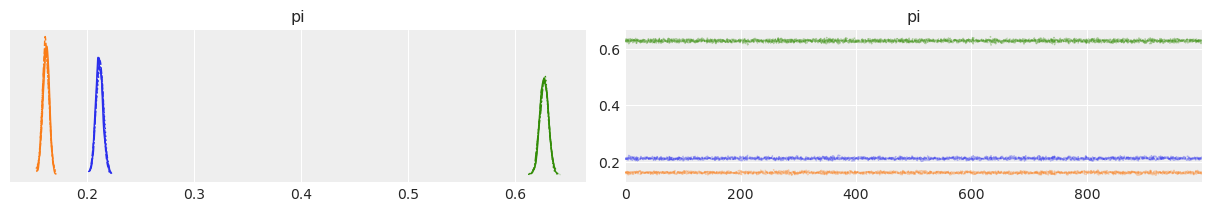

In [15]:
az.plot_trace(samples)

### Modified Model

Next we try a modified model that tries to estimate the posterior probabilities with the Multinomial distribution but we incorporate the *airline_sentiment_confidence* to estimate the posterior probabilities. Again we specifiy strong priors for the airline sentiments that follow a Dirichlet distribution and here the airline confidence score can take on values between 0 and 1 so it follows a Uniform distribution. We calculate the log-odds ratio of the sentiment probabilties and transform it to normalized probabilities using the softmax function.

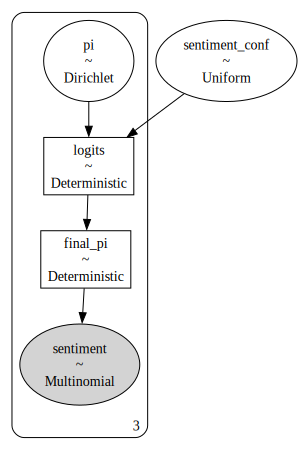

In [16]:
df['airline_sentiment'] = pd.factorize(df['airline_sentiment'])[0]
group_counts = df.groupby(['airline_sentiment']).size()

N = rows
priors = [2.0, 1.0, 5.0]

observed_counts = group_counts.values

num_sentiments = len(df['airline_sentiment'].unique())

with pm.Model() as modified_model:
    
    probs = pm.Dirichlet(name='pi',a=priors,shape=num_sentiments)
    sentiment_conf = pm.Uniform('sentiment_conf', lower=0, upper=1)
    
    logits = pm.Deterministic('logits', pm.math.dot(sentiment_conf, probs.T))

    final_probs = pm.Deterministic('final_pi', pm.math.softmax(logits))

    multinomial_dist = pm.Multinomial('sentiment', n=N, p=final_probs,observed=observed_counts)
      
pm.model_to_graphviz(modified_model)

Next we simulate data from the model and check the parameter summary table. We can see that the mean value for each posterior probability is close to the proportions in the observed data. The 94% highest density interval is also very narrow so that means we are fairly confident that the true proportions lies within this range. The $\hat{R}$, values are again all equal to one which suggests that the chains have converged. When looking at the trace plots below, it is clear that the parameters and its posteriors are moving together.

In [17]:
with modified_model:
    samples = pm.sample(1000, tune=1000, target_accept=0.99)
    
summary = pm.summary(samples)
summary

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [pi, sentiment_conf]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 38 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
pi[0],0.002,0.002,0.000,0.005,0.0,0.0,2101.0,1981.0,1.0
pi[1],0.001,0.001,0.000,0.002,0.0,0.0,1621.0,1476.0,1.0
pi[2],0.997,0.002,0.994,1.000,0.0,0.0,3021.0,1932.0,1.0
sentiment_conf,0.999,0.001,0.996,1.000,0.0,0.0,1366.0,1014.0,1.0
logits[0],0.002,0.002,0.000,0.005,0.0,0.0,2101.0,1981.0,1.0
logits[1],0.001,0.001,0.000,0.002,0.0,0.0,1620.0,1476.0,1.0
logits[2],0.996,0.002,0.991,0.999,0.0,0.0,2556.0,2319.0,1.0
final_pi[0],0.213,0.001,0.212,0.214,0.0,0.0,2408.0,2227.0,1.0
final_pi[1],0.212,0.000,0.212,0.213,0.0,0.0,2647.0,2267.0,1.0
final_pi[2],0.575,0.001,0.573,0.576,0.0,0.0,2772.0,2199.0,1.0


array([[<Axes: title={'center': 'pi'}>, <Axes: title={'center': 'pi'}>],
       [<Axes: title={'center': 'sentiment_conf'}>,
        <Axes: title={'center': 'sentiment_conf'}>],
       [<Axes: title={'center': 'logits'}>,
        <Axes: title={'center': 'logits'}>],
       [<Axes: title={'center': 'final_pi'}>,
        <Axes: title={'center': 'final_pi'}>]], dtype=object)

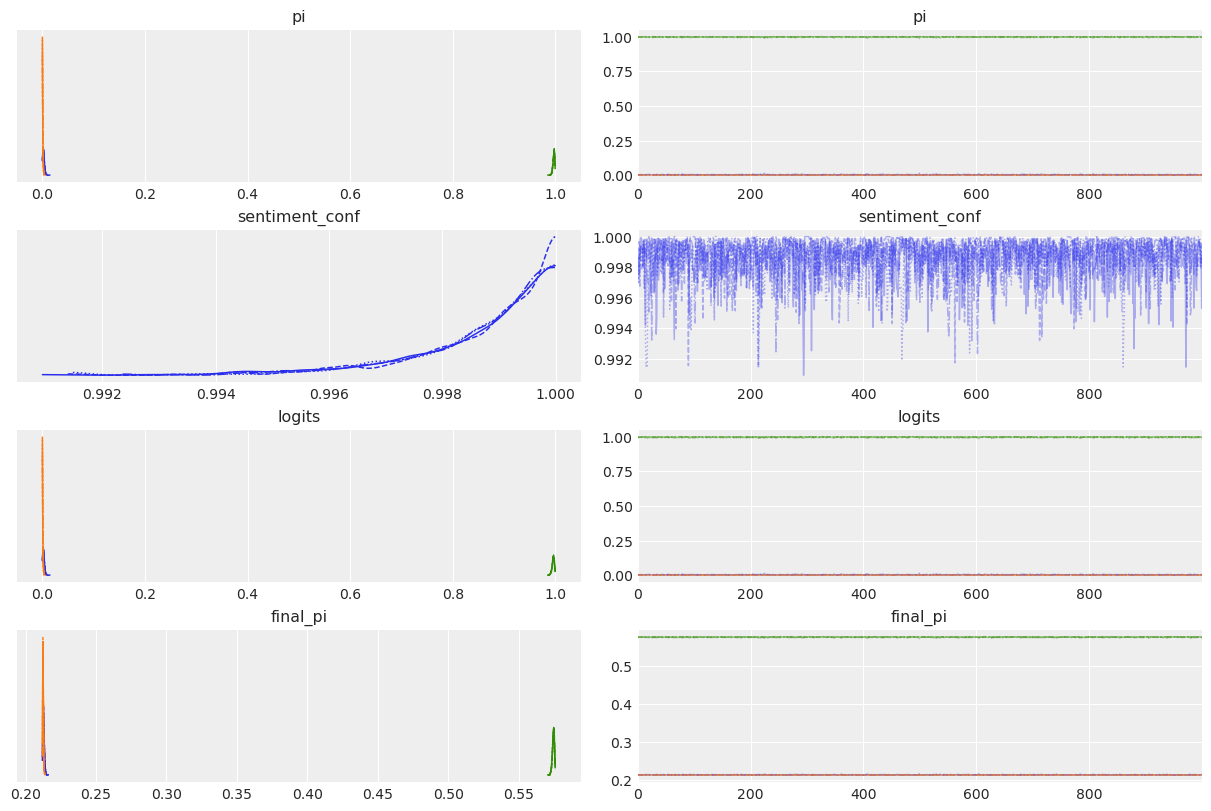

In [18]:
az.plot_trace(samples)